In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import argrelmin, argrelmax

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

import inspect

Using TensorFlow backend.


In [2]:
#Check Versions
print(tf.__version__)  # 1.15.0
print(keras.__version__)  # 2.2.4

1.15.0
2.2.4


# Alternative DCTR fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at truth level (before detector simulation) while the fit happens in data (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at detector-level or both happen at truth-level.  This notebook illustrates an alternative procedure:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_i)-\sum_{i\in\bf{\theta}}(f(x_i,\theta')/(1-f(x_i,\theta')))\log (1-g(x_i)))$

where the $f(x,\theta')/(1-f(x,\theta'))$ is the reweighting function.  The intuition of the above equation is that the classifier $g$ is trying to distinguish the two samples and we try to find a $\theta$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples, then the reweighting has worked!  This is similar to the minimax graining of a GAN, only now the analog of the generator network is the reweighting network which is fixed and thus the only trainable parameters are the $\theta'$.  The advantage of this second approach is that it readily generalizes to the case where the reweighting happens on a different level:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_{D,i})-\sum_{i\in\bf{\theta}}\frac{f(x_{T,i},\theta')}{(1-f(x_{T,i},\theta'))}\log (1-g(x_{D,i})))$

where $x_T$ is the truth value and $x_D$ is the detector-level value.  In simulation (the second sum), these come in pairs and so one can apply the reweighting on one level and the classification on the other.  Asympotitically, both this method and the one in the body of the DCTR paper learn the same result: $\theta^*=\theta_0$.

# Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the first Gaussian Notebook.

We will now parametrize our network by giving it a $\mu$ value in addition to $X_i\sim\mathcal{N}(\mu, 1)$.

First we uniformly sample $\mu$ values in some range

In [3]:
n_data_points = 10**6
mu_min = -2
mu_max = 2
mu_values = np.random.uniform(mu_min, mu_max, n_data_points)

We then sample from normal distributions with this $\mu$ value

In [4]:
X0 = [(np.random.normal(0, 1), mu)
      for mu in mu_values]  # Note the zero in normal(0, 1)
X1 = [(np.random.normal(mu, 1), mu) for mu in mu_values]

Please note that the samples in X0 are not paired with $\mu=0$ as this would make the task trivial. 

Instead it is paired with the $\mu$ values uniformly sampled in the specified range [mu_min, mu_max].

For every value of $\mu$ in mu_values, the network sees one event drawn from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,1)$, and it learns to classify them. 

I.e. we have one network that's parametrized by $\mu$ that classifies between events from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,1)$, and a trained network will give us the likelihood ratio to reweight from one to another. 

In [5]:
Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Build Model

In [6]:
inputs = Input((2, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs=inputs, outputs=outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam')

## Train DCTR model

In [7]:
earlystopping = EarlyStopping(patience=10, restore_best_weights=True)
dctr_model.fit(X_train,
               Y_train,
               epochs=200,
               batch_size=10000,
               validation_data=(X_test, Y_test),
               callbacks=[earlystopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1600000 samples, validate on 400000 samples
Epoch 1/200





1600000/1600000 [==============================] - 4s 2us/step - loss: 0.5806 - val_loss: 0.5643
Epoch 2/200
1600000/1600000 [==============================] - 3s 2us/step - loss: 0.5630 - val_loss: 0.5631
Epoch 3/200
1600000/1600000 [==============================] - 3s 2us/step - loss: 0.5627 - val_loss: 0.5633
Epoch 4/200
1600000/1600000 [==============================] - 3s 2us/step - loss: 0.5626 - val_loss: 0.5631
Epoch 5/200
1600000/1600000 [==============================] - 3s 2us/step - loss: 0.5626 - val_loss: 0.5631
Epoch 6/200
1600000/1600000 [==============================] - 3s 2us/step - loss: 0.5625 - val_loss: 0.5632
Epoch 7/200
1600000/1600000 [==============================] - 3s 2us/step - loss: 0.5625 - val_loss: 0.5629
Epoch 8/200
1600000/1600000 [==============================] - 3s 2us/step - loss:

## Saving Model

In [8]:
'''
model_json = dctr_model.to_json()
with open("1d_gaussian_dctr_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dctr_model.save_weights("1d_gaussian_dctr_model.h5")
print("Saved model to disk")
'''

'\nmodel_json = dctr_model.to_json()\nwith open("1d_gaussian_dctr_model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\ndctr_model.save_weights("1d_gaussian_dctr_model.h5")\nprint("Saved model to disk")\n'

### Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [9]:
# from NN (DCTR)
def reweight(events, param):

    #creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape=events.shape) * param
    #combining and reshaping into correct format:
    model_inputs = K.concatenate((events, concat_input_and_params), axis=-1)

    f = dctr_model(model_inputs)
    weights = (f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights


# from analytical formula for normal distributions
def analytical_reweight(events, param):
    mu0 = 0.0
    weights = K.exp(-(0.5 * (events - param)**2) + (0.5 * (events - mu0)**2))
    return weights

# Alternative Fit

## Setup the dataset

We'll show the new setup with a simple Gaussian example.  Let's start by setting up the dataset.

In [10]:
N = 10**6
theta0_param = 0  # this is the simulation ... N.B. this notation is reversed from above!
theta1_param = 1.  # this is the data (the target)

theta0 = np.random.normal(theta0_param, 1, N)
theta1 = np.random.normal(theta1_param, 1, N)
labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0, theta1])
yvals = np.concatenate([labels0, labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                    yvals,
                                                    test_size=0.5)
X_train_theta, Y_train_theta = shuffle(xvals, yvals)

## Fitting Model: Scan

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

### Loading Model

In [11]:
# load json and create model
'''
json_file = open('1d_gaussian_dctr_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dctr_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
dctr_model.load_weights("1d_gaussian_dctr_model.h5")
print("Loaded model from disk")
'''

'\njson_file = open(\'1d_gaussian_dctr_model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\ndctr_model = keras.models.model_from_json(loaded_model_json)\n# load weights into new model\ndctr_model.load_weights("1d_gaussian_dctr_model.h5")\nprint("Loaded model from disk")\n'

### Creating Model

In [12]:
myinputs = Input(shape=(1, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model = Model(inputs=myinputs, outputs=predictions)
model.summary()


def my_loss_wrapper(inputs,
                    val=0.,
                    reweight_analytically=False,
                    MSE_loss=True):
    x = inputs
    x = K.gather(x, np.arange(500))

    theta_prime = val

    if reweight_analytically:
        # analytical reweight
        weights = analytical_reweight(x, theta_prime)
    else:
        # NN (DCTR) reweight
        weights = reweight(x, theta_prime)

    def my_loss(y_true, y_pred):
        if MSE_loss:
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + weights * (
                1. - y_true) * (y_true - y_pred)**2
        else:
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))

        return K.mean(t_loss)

    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


### Training Model

In [13]:
thetas = np.linspace(-2, 2, 21)
lvals = []
vlvals = []

earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

for theta in thetas:
    print("testing theta = :", theta)
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper(myinputs, theta, MSE_loss=True),
                  metrics=['accuracy'])
    model.fit(np.array(X_train),
              y_train,
              epochs=100,
              batch_size=500,
              validation_data=(np.array(X_test), y_test),
              verbose=1,
              callbacks=[earlystopping])
    lvals += [np.min(model.history.history['loss'])]
    vlvals += [np.min(model.history.history['val_loss'])]
    print
    pass
print(lvals)

testing theta = : -2.0
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.0530 - acc: 0.6214 - val_loss: 0.0518 - val_acc: 0.6167
Epoch 2/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.0517 - acc: 0.6201 - val_loss: 0.0517 - val_acc: 0.6202
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.0517 - acc: 0.6201 - val_loss: 0.0520 - val_acc: 0.6153
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.0517 - acc: 0.6197 - val_loss: 0.0517 - val_acc: 0.6187
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.0517 - acc: 0.6200 - val_loss: 0.0518 - val_acc: 0.6201
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.0517 - acc: 0.6199 - val_loss: 0.0518 - val_acc: 0.6210
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - 

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.0982 - acc: 0.6614 - val_loss: 0.0982 - val_acc: 0.6619
Epoch 14/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.0982 - acc: 0.6608 - val_loss: 0.0982 - val_acc: 0.6614
testing theta = : -1.0
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.1132 - acc: 0.6707 - val_loss: 0.1133 - val_acc: 0.6724
Epoch 2/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.1132 - acc: 0.6710 - val_loss: 0.1133 - val_acc: 0.6731
Epoch 3/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.1132 - acc: 0.6714 - val_loss: 0.1132 - val_acc: 0.6728
Epoch 4/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.1132 - acc: 0.6712 - val_loss: 0.1133 - val_acc: 0.6727
Epoch 5/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.113

1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2145 - acc: 0.6908 - val_loss: 0.2142 - val_acc: 0.6907
Epoch 2/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2145 - acc: 0.6907 - val_loss: 0.2143 - val_acc: 0.6912
Epoch 3/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2144 - acc: 0.6908 - val_loss: 0.2143 - val_acc: 0.6899
Epoch 4/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2144 - acc: 0.6909 - val_loss: 0.2143 - val_acc: 0.6905
Epoch 5/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2145 - acc: 0.6908 - val_loss: 0.2143 - val_acc: 0.6904
Epoch 6/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2144 - acc: 0.6909 - val_loss: 0.2143 - val_acc: 0.6899
testing theta = : 0.40000000000000036
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 10s 10us/

Epoch 5/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2472 - acc: 0.3517 - val_loss: 0.2467 - val_acc: 0.3469
Epoch 6/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2472 - acc: 0.3488 - val_loss: 0.2467 - val_acc: 0.3531
Epoch 7/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2471 - acc: 0.3498 - val_loss: 0.2467 - val_acc: 0.3612
testing theta = : 1.4000000000000004
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2403 - acc: 0.3482 - val_loss: 0.2398 - val_acc: 0.3454
Epoch 2/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2403 - acc: 0.3472 - val_loss: 0.2400 - val_acc: 0.3428
Epoch 3/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2402 - acc: 0.3479 - val_loss: 0.2398 - val_acc: 0.3529
Epoch 4/100
1000000/1000000 [==============================] 

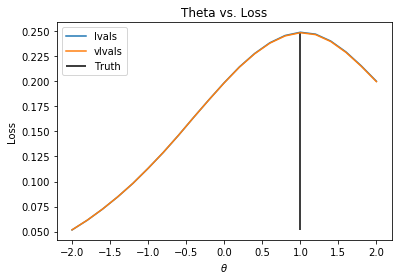

In [14]:
plt.title("Theta vs. Loss")
plt.plot(thetas, lvals, label='lvals')
plt.plot(thetas, vlvals, label='vlvals')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(np.mean(theta1),
           ymin=np.min(lvals),
           ymax=np.max(lvals),
           label='Truth')
plt.legend()
plt.show()

We've shown for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$

Now, let's do the $\theta$ and $g$ optimization together with a minimax setup.

## Building and Training Fitting Model: Gradient Fit

In [15]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(
    ". theta fit = ", model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = 0
fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(
    on_epoch_end=lambda batch, logs: fit_vals.append(model_fit.layers[-1].
                                                     get_weights()[0]))

callbacks = [print_weights, append_fit_value]

earlystopping = EarlyStopping(patience=10, restore_best_weights=True)

In [16]:
myinputs_fit = Input(shape=(1, ))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers) - 1].add_weight(
    name="thetaX",
    shape=list(),
    initializer=keras.initializers.Constant(value=theta_fit_init),
    trainable=True)
model_fit.summary()

batch_size = 2 * N  # for training theta only
iterations = 50

# optimizer will be refined as fit progresses for better precision
lr_initial = 5e-1
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])


def my_loss_wrapper_fit(
        inputs,
        mysign=1,  # -1 for training theta, +1 for training g
        reweight_analytically=False,
        MSE_loss=True):
    
    x = inputs

    # Getting theta_prime and fixing batch size:
    if mysign == 1:
        # regular batch size
        x = K.gather(x, np.arange(1000))
        #  when not training theta, fetch as np array
        theta_prime = model_fit.layers[-1].get_weights()
    else:
        # special theta batch size
        x = K.gather(x, np.arange(batch_size))
        # when training theta, fetch as tf.Variable
        theta_prime = model_fit.trainable_weights[-1]

    if reweight_analytically:
        # analytical reweight
        weights = analytical_reweight(x, theta_prime)
    else:
        # NN reweight
        weights = reweight(x, theta_prime)

    def my_loss(y_true, y_pred):
        if MSE_loss:
            # Mean Squared Loss
            t_loss = mysign * (y_true * (y_true - y_pred)**2 + weights *
                               (1. - y_true) * (y_true - y_pred)**2)
        else:
            # Categorical Cross-Entropy Loss
            #Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -mysign * ((y_true) * K.log(y_pred) + weights *
                                (1 - y_true) * K.log(1 - y_pred))

        return K.mean(t_loss)

    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 1         
Total params: 16,898
Trainable params: 16,898
Non-trainable params: 0
_________________________________________________________________


In [17]:
for iteration in range(iterations):
    print("Iteration: ", iteration)
    for i in range(len(model_fit.layers) - 1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass

    model_fit.layers[-1].trainable = False
    #model.summary()

    # regular optimizer and batch size
    model_fit.compile(optimizer=keras.optimizers.Adam(),
                      loss=my_loss_wrapper_fit(myinputs_fit, 1,
                                               MSE_loss=False),
                      metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train),
                  y_train,
                  epochs=100,
                  batch_size=1000,
                  validation_data=(np.array(X_test), y_test),
                  verbose=1,
                  callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True

    # special optimizer and batch size = 2*N
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit(myinputs_fit,
                                               -1,
                                               MSE_loss=False),
                      metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta),
                  Y_train_theta,
                  epochs=1,
                  batch_size=batch_size,
                  verbose=1,
                  callbacks=callbacks)

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_recent = np.array(fit_vals)[(index_refine[-1]):]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior

    extrema = np.concatenate(
        (argrelmin(fit_vals_recent)[0], argrelmax(fit_vals_recent)[0]))
    extrema = extrema[extrema >= iteration - index_refine[-1] - 20]

    #     print("index_refine", index_refine)
    #     print("extrema", extrema)

    #     if (len(extrema) == 0
    #         ):  # If none are found, keep fitting (catching index error)
    #         pass
    if (len(extrema) >= 6):  #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================')
        optimizer.lr = optimizer.lr / 10.
    pass

Iteration:  0
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.5828 - acc: 0.6910 - val_loss: 0.5812 - val_acc: 0.6918
Epoch 2/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.5817 - acc: 0.6919 - val_loss: 0.5814 - val_acc: 0.6918
Epoch 3/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.5817 - acc: 0.6920 - val_loss: 0.5816 - val_acc: 0.6916
Epoch 4/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.5817 - acc: 0.6920 - val_loss: 0.5813 - val_acc: 0.6915
Epoch 5/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.5816 - acc: 0.6919 - val_loss: 0.5811 - val_acc: 0.6918
Epoch 6/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.5816 - acc: 0.6920 - val_loss: 0.5812 - val_acc: 0.6918
Epoch 7/100
1000000/1000000 [==============================] - 6s 6us/step 

1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6876 - acc: 0.3498 - val_loss: 0.6862 - val_acc: 0.3542
Epoch 8/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6876 - acc: 0.3490 - val_loss: 0.6862 - val_acc: 0.3497
Epoch 9/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6876 - acc: 0.3490 - val_loss: 0.6862 - val_acc: 0.3553
Epoch 10/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6876 - acc: 0.3491 - val_loss: 0.6863 - val_acc: 0.3646
Epoch 11/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6876 - acc: 0.3494 - val_loss: 0.6862 - val_acc: 0.3576
Epoch 12/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6876 - acc: 0.3497 - val_loss: 0.6863 - val_acc: 0.3356
Epoch 13/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6876 - acc: 0.3473 - val_loss: 0.6862 - val_acc: 0.3458
Epoch 14/100
1000000/

Epoch 18/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6882 - acc: 0.3502 - val_loss: 0.6868 - val_acc: 0.3491
Epoch 19/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6882 - acc: 0.3504 - val_loss: 0.6868 - val_acc: 0.3610
Epoch 20/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6882 - acc: 0.3513 - val_loss: 0.6868 - val_acc: 0.3464
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 6s 3us/step - loss: -0.6875 - acc: 0.3535
. theta fit =  0.9125772
Iteration:  6
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6890 - acc: 0.6481 - val_loss: 0.6874 - val_acc: 0.6908
Epoch 2/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6886 - acc: 0.6857 - val_loss: 0.6874 - val_acc: 0.6871
Epoch 3/100
1000000/1000000 [==============================] - 6s 6us/

Epoch 3/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6886 - acc: 0.3520 - val_loss: 0.6872 - val_acc: 0.3492
Epoch 4/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6886 - acc: 0.3498 - val_loss: 0.6872 - val_acc: 0.3652
Epoch 5/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6886 - acc: 0.3518 - val_loss: 0.6872 - val_acc: 0.3553
Epoch 6/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6886 - acc: 0.3518 - val_loss: 0.6873 - val_acc: 0.3421
Epoch 7/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6886 - acc: 0.3509 - val_loss: 0.6873 - val_acc: 0.3488
Epoch 8/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6886 - acc: 0.3510 - val_loss: 0.6872 - val_acc: 0.3599
Epoch 9/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6885 - acc: 0.3513 - val_loss: 0.6873 - val_acc: 0.3424
Epoch 10/100


Epoch 13/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6898 - acc: 0.3757 - val_loss: 0.6884 - val_acc: 0.3847
Epoch 14/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6898 - acc: 0.3724 - val_loss: 0.6885 - val_acc: 0.3801
Epoch 15/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6898 - acc: 0.3712 - val_loss: 0.6885 - val_acc: 0.3695
Epoch 16/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6897 - acc: 0.3725 - val_loss: 0.6885 - val_acc: 0.3804
Epoch 17/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6897 - acc: 0.3751 - val_loss: 0.6886 - val_acc: 0.3520
Epoch 18/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6898 - acc: 0.3725 - val_loss: 0.6885 - val_acc: 0.3722
Epoch 19/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6898 - acc: 0.3756 - val_loss: 0.6886 - val_acc: 0.3366
Traini

Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.6907 - acc: 0.5376 - val_loss: 0.6894 - val_acc: 0.5738
Epoch 2/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6907 - acc: 0.5440 - val_loss: 0.6894 - val_acc: 0.5167
Epoch 3/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6907 - acc: 0.5454 - val_loss: 0.6894 - val_acc: 0.4603
Epoch 4/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6907 - acc: 0.5329 - val_loss: 0.6894 - val_acc: 0.5712
Epoch 5/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6907 - acc: 0.5387 - val_loss: 0.6894 - val_acc: 0.5495
Epoch 6/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6907 - acc: 0.5482 - val_loss: 0.6895 - val_acc: 0.5267
Epoch 7/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6907 - acc: 0

Training theta
Epoch 1/1
2000000/2000000 [==============================] - 7s 4us/step - loss: -0.6900 - acc: 0.4740
. theta fit =  1.0173559
Iteration:  19
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.6907 - acc: 0.5322 - val_loss: 0.6894 - val_acc: 0.5338
Epoch 2/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6907 - acc: 0.5399 - val_loss: 0.6894 - val_acc: 0.5206
Epoch 3/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6907 - acc: 0.5439 - val_loss: 0.6894 - val_acc: 0.4991
Epoch 4/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6907 - acc: 0.5345 - val_loss: 0.6894 - val_acc: 0.5333
Epoch 5/100
1000000/1000000 [==============================] - 6s 6us/step - loss: 0.6907 - acc: 0.5410 - val_loss: 0.6894 - val_acc: 0.5508
Epoch 6/100
1000000/1000000 [==============================] - 6s 6us/

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.5423 - val_loss: 0.6894 - val_acc: 0.5503
Epoch 14/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.5378 - val_loss: 0.6894 - val_acc: 0.5459
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 8s 4us/step - loss: -0.6900 - acc: 0.5854
. theta fit =  1.0197263
Iteration:  22
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.6907 - acc: 0.5390 - val_loss: 0.6895 - val_acc: 0.5243
Epoch 2/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.5242 - val_loss: 0.6895 - val_acc: 0.5529
Epoch 3/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.5253 - val_loss: 0.6894 - val_acc: 0.5321
Epoch 4/100
1000000/1000000 [==============================] - 7s 7us/step - loss

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.5026 - val_loss: 0.6895 - val_acc: 0.4777
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 8s 4us/step - loss: -0.6900 - acc: 0.5182
. theta fit =  1.0276548
Iteration:  25
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 12s 12us/step - loss: 0.6907 - acc: 0.4922 - val_loss: 0.6895 - val_acc: 0.5576
Epoch 2/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4967 - val_loss: 0.6895 - val_acc: 0.5285
Epoch 3/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4963 - val_loss: 0.6895 - val_acc: 0.4898
Epoch 4/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.5005 - val_loss: 0.6895 - val_acc: 0.4762
Epoch 5/100
1000000/1000000 [==============================] - 7s 7us/step - loss:

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4777 - val_loss: 0.6894 - val_acc: 0.4550
Epoch 9/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4717 - val_loss: 0.6894 - val_acc: 0.4730
Epoch 10/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4714 - val_loss: 0.6894 - val_acc: 0.5061
Epoch 11/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4707 - val_loss: 0.6894 - val_acc: 0.4833
Epoch 12/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4767 - val_loss: 0.6895 - val_acc: 0.4834
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 9s 5us/step - loss: -0.6901 - acc: 0.4511
. theta fit =  1.0303243
Iteration:  28
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 12s 12us/step - lo

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4741 - val_loss: 0.6894 - val_acc: 0.4403
Epoch 7/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4750 - val_loss: 0.6895 - val_acc: 0.4441
Epoch 8/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4745 - val_loss: 0.6895 - val_acc: 0.4961
Epoch 9/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4842 - val_loss: 0.6894 - val_acc: 0.4656
Epoch 10/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4687 - val_loss: 0.6894 - val_acc: 0.4445
Epoch 11/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4702 - val_loss: 0.6895 - val_acc: 0.4939
Epoch 12/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4687 - val_loss: 0.6895 - val_acc: 0.4700
Epoch 13/100
1000000/1

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4858 - val_loss: 0.6894 - val_acc: 0.4898
Epoch 9/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4782 - val_loss: 0.6894 - val_acc: 0.5131
Epoch 10/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4926 - val_loss: 0.6894 - val_acc: 0.4466
Epoch 11/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4779 - val_loss: 0.6894 - val_acc: 0.4899
Epoch 12/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4896 - val_loss: 0.6894 - val_acc: 0.4595
Epoch 13/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4874 - val_loss: 0.6894 - val_acc: 0.5299
Epoch 14/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4831 - val_loss: 0.6894 - val_acc: 0.5010
Epoch 15/100
1000000

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4709 - val_loss: 0.6894 - val_acc: 0.4871
Epoch 11/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4787 - val_loss: 0.6895 - val_acc: 0.5018
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 10s 5us/step - loss: -0.6900 - acc: 0.4571
. theta fit =  1.0328285
Iteration:  38
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 14s 14us/step - loss: 0.6907 - acc: 0.4707 - val_loss: 0.6894 - val_acc: 0.4791
Epoch 2/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4765 - val_loss: 0.6894 - val_acc: 0.5045
Epoch 3/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4774 - val_loss: 0.6894 - val_acc: 0.4975
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - los

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4782 - val_loss: 0.6894 - val_acc: 0.4897
Epoch 6/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4805 - val_loss: 0.6894 - val_acc: 0.4844
Epoch 7/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4831 - val_loss: 0.6894 - val_acc: 0.4814
Epoch 8/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4773 - val_loss: 0.6894 - val_acc: 0.4832
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6907 - acc: 0.4782 - val_loss: 0.6895 - val_acc: 0.4844
Epoch 10/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6907 - acc: 0.4800 - val_loss: 0.6895 - val_acc: 0.4738
Epoch 11/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4760 - val_loss: 0.6894 - val_acc: 0.4949
Epoch 12/100
1000000/10

Epoch 25/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6907 - acc: 0.4741 - val_loss: 0.6894 - val_acc: 0.4397
Epoch 26/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4721 - val_loss: 0.6894 - val_acc: 0.4967
Epoch 27/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4795 - val_loss: 0.6895 - val_acc: 0.4607
Epoch 28/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4756 - val_loss: 0.6894 - val_acc: 0.4908
Epoch 29/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4810 - val_loss: 0.6894 - val_acc: 0.4889
Epoch 30/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4842 - val_loss: 0.6894 - val_acc: 0.4471
Epoch 31/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4734 - val_loss: 0.6895 - val_acc: 0.4454
Epoch 

. theta fit =  1.0328821
Iteration:  46
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 16s 16us/step - loss: 0.6907 - acc: 0.4811 - val_loss: 0.6894 - val_acc: 0.4563
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6907 - acc: 0.4734 - val_loss: 0.6895 - val_acc: 0.4568
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6907 - acc: 0.4771 - val_loss: 0.6894 - val_acc: 0.5072
Epoch 4/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4801 - val_loss: 0.6895 - val_acc: 0.4445
Epoch 5/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6907 - acc: 0.4728 - val_loss: 0.6894 - val_acc: 0.4771
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6907 - acc: 0.4735 - val_loss: 0.6894 - val_acc: 0.5098
Epoch 7/100
1000000/1000000 [==================

1000000/1000000 [==============================] - 16s 16us/step - loss: 0.6907 - acc: 0.4798 - val_loss: 0.6894 - val_acc: 0.4877
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6907 - acc: 0.4802 - val_loss: 0.6895 - val_acc: 0.4847
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6907 - acc: 0.4787 - val_loss: 0.6895 - val_acc: 0.5070
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6907 - acc: 0.4794 - val_loss: 0.6894 - val_acc: 0.4595
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6907 - acc: 0.4753 - val_loss: 0.6894 - val_acc: 0.4634
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6907 - acc: 0.4795 - val_loss: 0.6894 - val_acc: 0.4767
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6907 - acc: 0.4743 - val_loss: 0.6895 - val_acc: 0.4796
Epoch 8/100
1000000/100

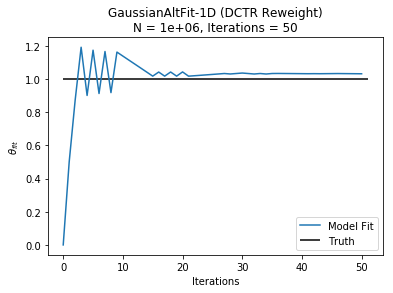

In [18]:
plt.plot(fit_vals, label='Model Fit')
plt.hlines(theta1_param, 0, len(fit_vals), label='Truth')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
plt.title("GaussianAltFit-1D (DCTR Reweight)\nN = {:.0e}, Iterations = {:.0f}".format(
    N, iterations))
# plt.savefig("GaussianAltFit-1D (DCTR Reweight)\nN = {:.0e}, Iterations = {:.0f}.png".format(
#     N, iterations)
plt.show()

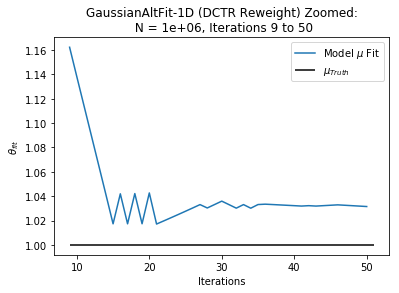

In [19]:
# Zoom into later iterations (finer fit)
fit_vals = np.array(fit_vals)
plt.title(
    "GaussianAltFit-1D (DCTR Reweight) Zoomed:\n N = {:.0e}, Iterations {:.0f} to {:.0f}".
    format(N, index_refine[1], iterations))
plt.plot(np.arange(index_refine[1], len(fit_vals)),
         fit_vals[index_refine[1]:],
         label='Model $\mu$ Fit')
plt.hlines(theta1_param, index_refine[1], len(fit_vals), label='$\mu_{Truth}$')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
# plt.savefig(
#     "GaussianAltFit-1D (DCTR Reweight) Zoomed:\n N = {:.0e}, Iterations {:.0f} to {:.0f}.png".
#     format(N, index_refine[1], iterations))
plt.show()

#### Compare Fitting between DCTR Reweighting and Analytical Reweighting

In [20]:
fit_vals = [theta_fit_init]
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])

In [21]:
for iteration in range(iterations):
    print("Iteration: ", iteration)
    for i in range(len(model_fit.layers) - 1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass

    model_fit.layers[-1].trainable = False
    #model.summary()

    # regular optimizer and batch size
    model_fit.compile(optimizer=keras.optimizers.Adam(),
                      loss=my_loss_wrapper_fit(myinputs_fit,
                                               1,
                                               reweight_analytically=True,
                                               MSE_loss=False),
                      metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train),
                  y_train,
                  epochs=100,
                  batch_size=1000,
                  validation_data=(np.array(X_test), y_test),
                  verbose=1,
                  callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True

    # special optimizer and batch size = 2*N
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit(myinputs_fit,
                                               -1,
                                               reweight_analytically=True,
                                               MSE_loss=False),
                      metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta),
                  Y_train_theta,
                  epochs=1,
                  batch_size=batch_size,
                  verbose=1,
                  callbacks=callbacks)

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_recent = np.array(fit_vals)[(index_refine[-1]):]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior

    extrema = np.concatenate(
        (argrelmin(fit_vals_recent)[0], argrelmax(fit_vals_recent)[0]))
    extrema = extrema[extrema >= iteration - index_refine[-1] - 20]

    #     print("index_refine", index_refine)
    #     print("extrema", extrema)

    #     if (len(extrema) == 0
    #         ):  # If none are found, keep fitting (catching index error)
    #         pass
    if (len(extrema) >= 6):  #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================')
        optimizer.lr = optimizer.lr / 10.
    pass

Iteration:  0
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 16s 16us/step - loss: 0.6937 - acc: 0.4119 - val_loss: 0.6924 - val_acc: 0.3217
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.3636 - val_loss: 0.6923 - val_acc: 0.3279
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.3502 - val_loss: 0.6923 - val_acc: 0.3401
Epoch 4/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6936 - acc: 0.3433 - val_loss: 0.6923 - val_acc: 0.3427
Epoch 5/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6935 - acc: 0.3491 - val_loss: 0.6923 - val_acc: 0.3928
Epoch 6/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.6935 - acc: 0.3487 - val_loss: 0.6923 - val_acc: 0.3397
Epoch 7/100
1000000/1000000 [==============================] - 7s 7us/ste

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6875 - acc: 0.3407 - val_loss: 0.6862 - val_acc: 0.3321
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6876 - acc: 0.3415 - val_loss: 0.6861 - val_acc: 0.3445
Epoch 8/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6876 - acc: 0.3405 - val_loss: 0.6861 - val_acc: 0.3433
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6875 - acc: 0.3415 - val_loss: 0.6861 - val_acc: 0.3412
Epoch 10/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6875 - acc: 0.3387 - val_loss: 0.6862 - val_acc: 0.3640
Epoch 11/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6876 - acc: 0.3428 - val_loss: 0.6861 - val_acc: 0.3418
Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6875 - acc: 0.3428 - val_loss: 0.6862 - val_acc: 0.3592
Epoch 13/100
1000000/1

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6933 - acc: 0.6740 - val_loss: 0.6920 - val_acc: 0.6916
Epoch 10/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6933 - acc: 0.6731 - val_loss: 0.6921 - val_acc: 0.6913
Epoch 11/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6933 - acc: 0.6708 - val_loss: 0.6921 - val_acc: 0.6446
Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6933 - acc: 0.6761 - val_loss: 0.6920 - val_acc: 0.6810
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 11s 6us/step - loss: -0.6926 - acc: 0.6710
. theta fit =  1.1973441
Iteration:  7
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 17s 17us/step - loss: 0.6897 - acc: 0.3439 - val_loss: 0.6875 - val_acc: 0.3489
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - lo

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6890 - acc: 0.3418 - val_loss: 0.6877 - val_acc: 0.3424
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6891 - acc: 0.3397 - val_loss: 0.6877 - val_acc: 0.3339
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6891 - acc: 0.3398 - val_loss: 0.6878 - val_acc: 0.3564
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6891 - acc: 0.3426 - val_loss: 0.6878 - val_acc: 0.3284
Epoch 8/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6891 - acc: 0.3417 - val_loss: 0.6877 - val_acc: 0.3367
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6891 - acc: 0.3408 - val_loss: 0.6877 - val_acc: 0.3425
Epoch 10/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6891 - acc: 0.3406 - val_loss: 0.6878 - val_acc: 0.3312
Epoch 11/100
1000000/100

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6919 - acc: 0.3370 - val_loss: 0.6905 - val_acc: 0.3319
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6918 - acc: 0.3353 - val_loss: 0.6905 - val_acc: 0.3540
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6919 - acc: 0.3370 - val_loss: 0.6907 - val_acc: 0.3197
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6919 - acc: 0.3368 - val_loss: 0.6905 - val_acc: 0.3431
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6918 - acc: 0.3381 - val_loss: 0.6905 - val_acc: 0.3299
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6919 - acc: 0.3361 - val_loss: 0.6905 - val_acc: 0.3456
Epoch 8/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6919 - acc: 0.3380 - val_loss: 0.6906 - val_acc: 0.3654
Epoch 9/100
1000000/10000

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6934 - acc: 0.3438 - val_loss: 0.6922 - val_acc: 0.3086
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6934 - acc: 0.3413 - val_loss: 0.6921 - val_acc: 0.3643
Epoch 10/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6934 - acc: 0.3446 - val_loss: 0.6921 - val_acc: 0.3616
Epoch 11/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6934 - acc: 0.3427 - val_loss: 0.6921 - val_acc: 0.3718
Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6934 - acc: 0.3440 - val_loss: 0.6921 - val_acc: 0.3589
Epoch 13/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6934 - acc: 0.3437 - val_loss: 0.6922 - val_acc: 0.3106
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 12s 6us/step - loss: -0.6927 - acc: 0.3457
. theta fit =  1.0243847
Iteration:  16
Tra

Epoch 21/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6937 - acc: 0.4864 - val_loss: 0.6924 - val_acc: 0.4564
Epoch 22/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6937 - acc: 0.4967 - val_loss: 0.6924 - val_acc: 0.4830
Epoch 23/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6937 - acc: 0.4755 - val_loss: 0.6924 - val_acc: 0.4800
Epoch 24/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.4983 - val_loss: 0.6924 - val_acc: 0.4713
Epoch 25/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6937 - acc: 0.4913 - val_loss: 0.6924 - val_acc: 0.4764
Epoch 26/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.4945 - val_loss: 0.6924 - val_acc: 0.4886
Epoch 27/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6937 - acc: 0.4912 - val_loss: 0.6924 - val_acc: 0.4609
Epoch 

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.4933 - val_loss: 0.6924 - val_acc: 0.4038
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.4534 - val_loss: 0.6924 - val_acc: 0.5631
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.4968 - val_loss: 0.6925 - val_acc: 0.4999
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6937 - acc: 0.4614 - val_loss: 0.6924 - val_acc: 0.4792
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.4728 - val_loss: 0.6924 - val_acc: 0.4580
Epoch 8/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6937 - acc: 0.4769 - val_loss: 0.6924 - val_acc: 0.4211
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6937 - acc: 0.4629 - val_loss: 0.6924 - val_acc: 0.4955
Epoch 10/100
1000000/1000

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6935 - acc: 0.6631 - val_loss: 0.6923 - val_acc: 0.6801
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6935 - acc: 0.6701 - val_loss: 0.6924 - val_acc: 0.6913
Epoch 10/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.6797 - val_loss: 0.6924 - val_acc: 0.6656
Epoch 11/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.6772 - val_loss: 0.6923 - val_acc: 0.6767
Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.6698 - val_loss: 0.6923 - val_acc: 0.6867
Epoch 13/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6935 - acc: 0.6732 - val_loss: 0.6923 - val_acc: 0.6741
Epoch 14/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.6682 - val_loss: 0.6923 - val_acc: 0.6799
Epoch 15/100
1000000

Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.3364 - val_loss: 0.6923 - val_acc: 0.3304
Epoch 13/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.3406 - val_loss: 0.6923 - val_acc: 0.3441
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 13s 7us/step - loss: -0.6929 - acc: 0.3285
. theta fit =  0.9979373
Iteration:  25
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 20s 20us/step - loss: 0.6937 - acc: 0.4155 - val_loss: 0.6924 - val_acc: 0.4363
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.4915 - val_loss: 0.6924 - val_acc: 0.5388
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.5255 - val_loss: 0.6924 - val_acc: 0.5439
Epoch 4/100
1000000/1000000 [==============================] - 8s 8

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6935 - acc: 0.6770 - val_loss: 0.6923 - val_acc: 0.6831
Epoch 29/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6935 - acc: 0.6774 - val_loss: 0.6923 - val_acc: 0.6686
Epoch 30/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6935 - acc: 0.6766 - val_loss: 0.6923 - val_acc: 0.6685
Epoch 31/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6935 - acc: 0.6692 - val_loss: 0.6923 - val_acc: 0.6875
Epoch 32/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6935 - acc: 0.6759 - val_loss: 0.6923 - val_acc: 0.6707
Epoch 33/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6935 - acc: 0.6754 - val_loss: 0.6924 - val_acc: 0.6564
Epoch 34/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6935 - acc: 0.6768 - val_loss: 0.6923 - val_acc: 0.6664
Epoch 35/100
100000

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.5077 - val_loss: 0.6924 - val_acc: 0.5332
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.5087 - val_loss: 0.6924 - val_acc: 0.5710
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.5214 - val_loss: 0.6924 - val_acc: 0.5101
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.5146 - val_loss: 0.6924 - val_acc: 0.5228
Epoch 7/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.5105 - val_loss: 0.6924 - val_acc: 0.5118
Epoch 8/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.5409 - val_loss: 0.6924 - val_acc: 0.5178
Epoch 9/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.5221 - val_loss: 0.6924 - val_acc: 0.4999
Epoch 10/100
1000000/1000

Epoch 13/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5817 - val_loss: 0.6924 - val_acc: 0.4955
Epoch 14/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.5398 - val_loss: 0.6924 - val_acc: 0.5404
Epoch 15/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.5179 - val_loss: 0.6924 - val_acc: 0.5470
Epoch 16/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5440 - val_loss: 0.6924 - val_acc: 0.5842
Epoch 17/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.6936 - acc: 0.5474 - val_loss: 0.6924 - val_acc: 0.5237
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 14s 7us/step - loss: -0.6930 - acc: 0.5324
. theta fit =  0.9999463
Iteration:  32
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 21s

Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 21s 21us/step - loss: 0.6936 - acc: 0.6056 - val_loss: 0.6924 - val_acc: 0.6900
Epoch 2/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.6012 - val_loss: 0.6924 - val_acc: 0.6917
Epoch 3/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.6221 - val_loss: 0.6924 - val_acc: 0.4999
Epoch 4/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5909 - val_loss: 0.6924 - val_acc: 0.5636
Epoch 5/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5799 - val_loss: 0.6924 - val_acc: 0.6154
Epoch 6/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5689 - val_loss: 0.6924 - val_acc: 0.5001
Epoch 7/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.69

Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 22s 22us/step - loss: 0.6936 - acc: 0.5587 - val_loss: 0.6924 - val_acc: 0.5807
Epoch 2/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5416 - val_loss: 0.6924 - val_acc: 0.5912
Epoch 3/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5540 - val_loss: 0.6924 - val_acc: 0.5446
Epoch 4/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5709 - val_loss: 0.6924 - val_acc: 0.5537
Epoch 5/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5548 - val_loss: 0.6924 - val_acc: 0.5516
Epoch 6/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5573 - val_loss: 0.6924 - val_acc: 0.5648
Epoch 7/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.69

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5115 - val_loss: 0.6924 - val_acc: 0.4293
Epoch 8/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5002 - val_loss: 0.6924 - val_acc: 0.5671
Epoch 9/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5255 - val_loss: 0.6924 - val_acc: 0.5763
Epoch 10/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5218 - val_loss: 0.6924 - val_acc: 0.5603
Epoch 11/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5156 - val_loss: 0.6924 - val_acc: 0.4386
Epoch 12/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.4815 - val_loss: 0.6924 - val_acc: 0.5415
Epoch 13/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5256 - val_loss: 0.6924 - val_acc: 0.5258
Epoch 14/100
1000000/

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5429 - val_loss: 0.6924 - val_acc: 0.4636
Epoch 15/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5367 - val_loss: 0.6924 - val_acc: 0.5709
Epoch 16/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5296 - val_loss: 0.6924 - val_acc: 0.5372
Epoch 17/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5365 - val_loss: 0.6924 - val_acc: 0.5016
Epoch 18/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5102 - val_loss: 0.6924 - val_acc: 0.4347
Epoch 19/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5181 - val_loss: 0.6924 - val_acc: 0.5529
Epoch 20/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5160 - val_loss: 0.6924 - val_acc: 0.5001
Epoch 21/100
100000

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5776 - val_loss: 0.6924 - val_acc: 0.5983
Epoch 15/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5791 - val_loss: 0.6924 - val_acc: 0.6004
Epoch 16/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5764 - val_loss: 0.6924 - val_acc: 0.5519
Epoch 17/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5596 - val_loss: 0.6924 - val_acc: 0.5991
Epoch 18/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.6936 - acc: 0.5467 - val_loss: 0.6924 - val_acc: 0.4999
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 14s 7us/step - loss: -0.6930 - acc: 0.5316
. theta fit =  0.9971774
Iteration:  49
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 23s 23us/step - 

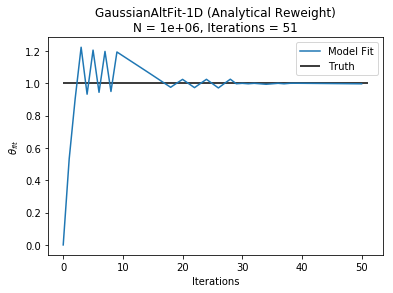

In [22]:
plt.plot(fit_vals, label='Model Fit')
plt.hlines(theta1_param, 0, len(fit_vals), label='Truth')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
plt.title("GaussianAltFit-1D (Analytical Reweight)\nN = {:.0e}, Iterations = {:.0f}".format(
    N, len(fit_vals)))
# plt.savefig("GaussianAltFit-1D (Analytical Reweight)\nN = {:.0e}, Iterations = {:.0f}.png".format(
#     N, iterations)
plt.show()

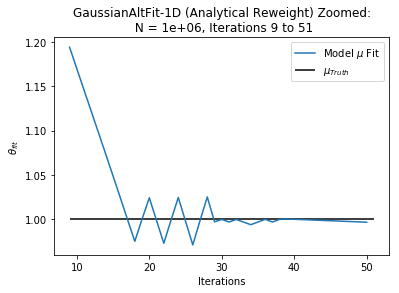

In [23]:
# Zoom into later iterations (finer fit)
fit_vals = np.array(fit_vals)
plt.title(
    "GaussianAltFit-1D (Analytical Reweight) Zoomed:\n N = {:.0e}, Iterations {:.0f} to {:.0f}".
    format(N, index_refine[1], len(fit_vals)))
plt.plot(np.arange(index_refine[1], len(fit_vals)),
         fit_vals[index_refine[1]:],
         label='Model $\mu$ Fit')
plt.hlines(theta1_param, index_refine[1], len(fit_vals), label='$\mu_{Truth}$')
plt.xlabel("Iterations")
plt.ylabel(r'$\theta_{fit}$')
plt.legend()
# plt.savefig(
#     "GaussianAltFit-1D (Analytical Reweight) Zoomed:\n N = {:.0e}, Iterations {:.0f} to {:.0f}.png".
#     format(N, index_refine[1], iterations))
plt.show()